In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [3]:
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "LangGraphAssignment" 
os.environ["LANGSMITH_TRACING"] = "true"

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
Embeddings= HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

d:\AGENTICAI_2.0\07-June_Langgraph\langgraph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [7]:
loader=TextLoader("D:/AGENTICAI_2.0/07-June_Langgraph/usa.txt")

In [8]:
docs=loader.load()

In [9]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [10]:
new_docs=text_splitter.split_documents(documents=docs)

In [11]:
db=Chroma.from_documents(new_docs,Embeddings)

In [12]:
retriever=db.as_retriever(search_kwargs={"k": 3})

In [40]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [41]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [42]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [43]:
from langchain.output_parsers import PydanticOutputParser


In [44]:
def fun1(state:AgentState):
    ques=state['messages'][-1]
    class TopicSelectionParser(BaseModel):
        Topic:str=Field(description="selected topic")
        Reasoning:str=Field(description='Reasoning behind topic selection')
    parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
    template="""
    Your task is to classify the given user query into one of the following categories: 
    - "Tool Call" for which LLM was not aware and need to search on internet
    - "RAG Call" for semantic document retrieval where Vector DB contains US GDP related information
    - "LLM Call" for which LLM already holds has some information about it
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    chain = prompt| model |parser
    response = chain.invoke({"question":ques})
    print("Parsed response:", response)
    return {"messages": [response.Topic]}

In [45]:
state = {"messages":["What is today's weather?"]}
fun1(state)

Parsed response: Topic='Tool Call' Reasoning='LLMs do not have real-time access to weather information; requires an external weather API or website.'


{'messages': ['Tool Call']}

In [46]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [47]:
def fun2(state:AgentState):
    print("RAG CALL")
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [48]:
def fun3(state:AgentState):
    print("LLM CALL")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "You are a helpful assistant to answer user query: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}


In [64]:
from langchain_tavily import TavilySearch
def fun4(state:AgentState):
    question=state["messages"][0]
    print("TOOL CALL")
    import os
    os.environ["TAVILY_API_KEY"] = os.environ.get("TAVILY_API_KEY")
    tool = TavilySearch(max_results=2,topic="general",)
    tool_msg=tool.invoke({"query": question})
    return {"messages":[tool_msg]}
    


In [50]:
def fun5(state:AgentState):
    category = state['messages'][-1]
    if "Tool Call" in category:
        return "Tool Call"
    elif "RAG Call" in category:
        return "RAG Call"
    elif "LLM Call" in category:
        return "LLM Call"
    else:
        return "None"

In [51]:
state = {'messages': ['Tool Call']}
fun5(state)

'Tool Call'

In [52]:
def fun6(state:AgentState):
    print("Validation")
    class ResponseValidation(BaseModel):
        answer: str = Field(..., description="The answer to the user's question")
    parser = PydanticOutputParser(pydantic_object=ResponseValidation)
    format_instructions = parser.get_format_instructions()
    resp=state["messages"][-1]
    question = state["messages"][0]
    prompt = f"""You are a helpful assistant. Please answer the following query clearly based on the context provided:{resp} Provide the response in this format:{format_instructions} Query: {question}"""
    result = model.invoke(prompt)
    try:
         parsed_output = parser.parse(result.content)
         print(f"parsed output : {parsed_output}")
         return {"messages":["Success"]}
    
    except Exception as e:
          print("parsing failed")
          return {"messages":["Supervisor Call"]}
          

In [53]:
def fun7(state:AgentState):
    print("Validation Router")
    valid_resp=state["messages"][-1]
    if "Success" in valid_resp:
        return "Success"
    else:
        return "Supervisor Call"

In [65]:
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",fun1)
workflow.add_node("RAG",fun2)
workflow.add_node("LLM",fun3)
workflow.add_node("Tool",fun4)
workflow.add_node("Validation", fun6)
workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
    "Supervisor",
    fun5,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "Tool Call": "Tool",
        "None": END
    }
)
workflow.add_edge("RAG", "Validation")
workflow.add_edge("Tool", "Validation")
workflow.add_edge("LLM", "Validation")
workflow.add_conditional_edges(
    "Validation",
    fun7,
    {
        "Success": END,
        "Supervisor Call": "Supervisor"
    }
)

In [66]:
app=workflow.compile()

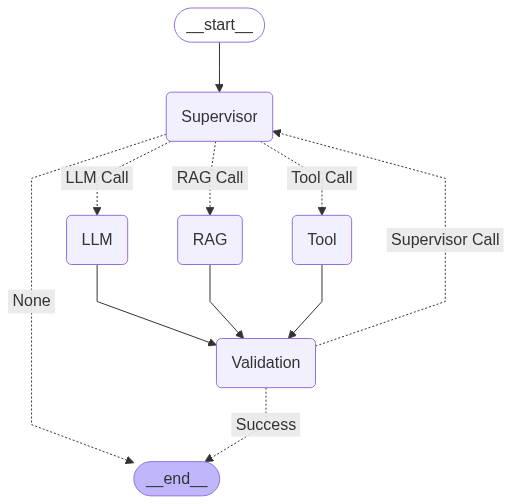

In [67]:
app

In [71]:
app.invoke({"messages":["What is GDP of USA?"]})

Parsed response: Topic='RAG Call' Reasoning='The query directly asks for a factual piece of information (US GDP) likely contained within a vector database of US GDP related information.'
RAG CALL
Validation
parsed output : answer='The estimated nominal GDP of the USA in 2024 is approximately $28 trillion, representing about 25% of the global economy.'
Validation Router


{'messages': ['What is GDP of USA?',
  'RAG Call',
  'The nominal GDP of the USA in 2024 is estimated to be around $28 trillion.  This represents about 25% of the global economy.  It holds the #1 spot worldwide for nominal GDP.',
  'Success']}

In [72]:
app.invoke({"messages":["How is weather today?"]})

Parsed response: Topic='Tool Call' Reasoning='LLM does not have real-time access to weather information; it requires an external weather API or service.'
TOOL CALL
Validation
parsed output : answer='It is currently cloudy in Harbour Island, Bahamas. The temperature is 27.1°C (80.7°F), but it feels like 30.4°C (86.7°F) due to the wind.  The wind is blowing from the ESE at 14.5 mph (23.4 kph) with gusts up to 20.1 mph (32.4 kph). There is 0.0 mm of precipitation and humidity is at 80%.'
Validation Router


{'messages': ['How is weather today?',
  'Tool Call',
  {'query': 'How is weather today?',
   'follow_up_questions': None,
   'answer': None,
   'images': [],
   'results': [{'title': 'Weather in current location',
     'url': 'https://www.weatherapi.com/',
     'content': "{'location': {'name': 'Current', 'region': 'Harbour Island', 'country': 'Bahamas', 'lat': 25.4333, 'lon': -76.7833, 'tz_id': 'America/Nassau', 'localtime_epoch': 1750272960, 'localtime': '2025-06-18 14:56'}, 'current': {'last_updated_epoch': 1750272300, 'last_updated': '2025-06-18 14:45', 'temp_c': 27.1, 'temp_f': 80.7, 'is_day': 1, 'condition': {'text': 'Cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/119.png', 'code': 1006}, 'wind_mph': 14.5, 'wind_kph': 23.4, 'wind_degree': 118, 'wind_dir': 'ESE', 'pressure_mb': 1021.0, 'pressure_in': 30.15, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 80, 'cloud': 63, 'feelslike_c': 30.4, 'feelslike_f': 86.7, 'windchill_c': 27.1, 'windchill_f': 80.7, 'heatindex_c': 3

In [73]:
app.invoke({"messages":["What is the sum of eight plus eight?"]})

Parsed response: Topic='LLM Call' Reasoning='This is a simple arithmetic problem that the LLM can solve without needing external resources or a vector database.'
LLM CALL
Validation
parsed output : answer='16'
Validation Router


{'messages': ['What is the sum of eight plus eight?',
  'LLM Call',
  'The sum of eight plus eight is 16.',
  'Success']}